In [66]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt

In [67]:
raw_data_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'raw')
csv_files = [f for f in os.listdir(raw_data_dir) if f.endswith('.csv')]

print(f"\nFound {len(csv_files)} CSV files:")
for f_name in csv_files:
        print(f"- {f_name}")


Found 31 CSV files:
- android_metadata.csv
- ascents.csv
- attempts.csv
- beta_links.csv
- bids.csv
- circuits.csv
- circuits_climbs.csv
- climbs.csv
- climb_cache_fields.csv
- climb_random_positions.csv
- climb_stats.csv
- difficulty_grades.csv
- holes.csv
- kits.csv
- layouts.csv
- leds.csv
- placements.csv
- placement_roles.csv
- products.csv
- products_angles.csv
- product_sizes.csv
- product_sizes_layouts_sets.csv
- sets.csv
- shared_syncs.csv
- sqlite_stat1.csv
- tags.csv
- users.csv
- user_permissions.csv
- user_syncs.csv
- walls.csv
- walls_sets.csv


In [68]:
holes_csv_path = os.path.join(raw_data_dir, 'holes.csv')
placements_csv_path = os.path.join(raw_data_dir, 'placements.csv')



df_holes = pd.read_csv(holes_csv_path)
df_placements = pd.read_csv(placements_csv_path)

In [61]:
df_holes = df_holes.drop(["mirrored_hole_id", "mirror_group", "name", "product_id"], axis=1)
df_holes = df_holes.rename(columns={'id': 'hole_id'})
df_holes


,hole_id,x,y
0,1133,140,4
1,1134,136,8
2,1135,132,4
3,1136,128,8
4,1137,124,4
...,...,...,...
3289,4422,148,116
3290,4423,164,116
3291,4424,156,124
3292,4425,148,132


In [62]:
df_placements = df_placements.rename(columns={'id': 'placement_id', 'default_placement_role_id': 'default_role_id'})
df_placements

,placement_id,layout_id,hole_id,set_id,default_role_id
0,1073,1,1134,1,13.0
1,1074,1,1136,1,13.0
2,1075,1,1138,1,13.0
3,1076,1,1140,1,13.0
4,1077,1,1142,1,13.0
...,...,...,...,...,...
3768,4676,8,4172,29,45.0
3769,4677,8,4174,29,45.0
3770,4678,8,4176,29,45.0
3771,4679,8,4178,29,45.0


In [65]:
merged_df = pd.merge(df_holes, df_placements, on='hole_id')
merged_df["hold_color"] = 'black'
merged_df.loc[merged_df["default_role_id"] == 15, "hold_color"] = 'gray'
rearranged_columns = ["placement_id","hole_id",
                                        "layout_id","set_id",
                                        "x", "y", 
                                        "default_role_id",
                                        "hold_color"]
merged_df = merged_df[rearranged_columns]
merged_df = merged_df.reset_index(drop=True)
merged_df[merged_df["layout_id"] == 1]


,placement_id,hole_id,layout_id,set_id,x,y,default_role_id,hold_color
0,1447,1133,1,20,140,4,15.0,gray
1,1073,1134,1,1,136,8,13.0,black
2,1448,1135,1,20,132,4,15.0,gray
3,1074,1136,1,1,128,8,13.0,black
4,1449,1137,1,20,124,4,15.0,gray
...,...,...,...,...,...,...,...,...
3768,4841,4422,1,20,148,116,15.0,gray
3769,4842,4423,1,20,164,116,15.0,gray
3770,4843,4424,1,20,156,124,15.0,gray
3771,4844,4425,1,20,148,132,15.0,gray


In [17]:
def parse_p_r_string(text_string, color_map):
    """
    Separates a string like 'p1145r12...' into a pandas DataFrame
    with (number, r_value) pairs.

    """
    pattern = r'p(\d{4})(r\d{2})'

    extracted_pairs = re.findall(pattern, text_string)

    df = pd.DataFrame(extracted_pairs, columns=['placement_id', 'hold_type'])

    df['placement_id'] = df['placement_id'].astype(int)

    df['hold_color'] = df['hold_type'].map(color_map)

    return df

# Your input string
my_string = 'p1096r12p1159r15p1200r12p1247r13p1249r13p1262r13p1318r13p1369r13p1390r14p1495r15p1498r15p1551r15'

# Your color map
color_map = {'r12': 'green',
             'r13': 'blue',
             'r14': 'red',
             'r15': 'yellow'}

# Get the DataFrame
result_df = parse_p_r_string(my_string, color_map)

print(result_df)

    placement_id hold_type hold_color
0           1096       r12      green
1           1159       r15     yellow
2           1200       r12      green
3           1247       r13       blue
4           1249       r13       blue
5           1262       r13       blue
6           1318       r13       blue
7           1369       r13       blue
8           1390       r14        red
9           1495       r15     yellow
10          1498       r15     yellow
11          1551       r15     yellow


In [32]:
color_mapping_series = result_df.set_index('placement_id')['hold_color']
mapped_colors = merged_df['placement_id'].map(color_mapping_series)
merged_df['hold_color'] = mapped_colors.fillna(merged_df['hold_color'])


In [37]:
gecko_board = merged_df[merged_df["layout_id"] == 1]
gecko_board = gecko_board[gecko_board["placement_id"] < 4000]
gecko_board = gecko_board[gecko_board["y"] < 160]

#xmax = np.max(merged_df[merged_df["layout_id"] == 1]["x"])
#xmin = np.min(merged_df[merged_df["layout_id"] == 1]["x"])
#ymax = np.max(merged_df[merged_df["layout_id"] == 1]["y"])
#ymin = np.min(merged_df[merged_df["layout_id"] == 1]["y"])
#print(xmax, xmin)
#print(ymax, ymin)

(0.0, 160.0)

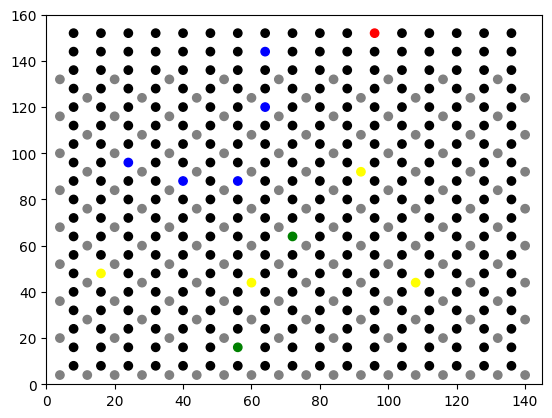

In [38]:
plt.scatter(gecko_board["x"], gecko_board["y"], c=gecko_board["hold_color"])
plt.xlim(0, 145)
plt.ylim(0, 160)

In [ ]:
#gecko_board.shape

(476, 10)

In [42]:
gecko_board.columns

Index(['hole_id', 'product_id', 'name', 'x', 'y', 'placement_id', 'layout_id',
       'set_id', 'default_role_id', 'hold_color'],
      dtype='object')